### *The goal*

#### One of the taxi companies provided historical data on taxi orders at airports. To attract more drivers during peak periods, we need to predict the number of taxi orders for the next hour and build a model for this.

#### *RMSE* metric value on the test sample should be no more than 48.

## Content ##

[*Part 1. Data Preparation*](#part1)

[*Part 2. EDA*](#part2)

[*Part 3. Training*](#part3)

[*Part 4. Testing*](#part4)

## Part 1. Data Preparation <a id='part1'></a>

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import math

In [2]:
data = pd.read_csv('taxi.csv')

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


The dataset contains data on the number of orders with an interval of 10 minutes. The first column is with dates, the second with the number of orders. There are 2 columns and 26496 rows in total. Dates are presented in text format, the number of orders is in integer format.

In [5]:
data['datetime'] = pd.to_datetime(data['datetime']) #let's convert dates to a special format with dates

In [6]:
data = data.set_index('datetime') #Let's make the dates as indexes of the table

In [7]:
data.sort_index(inplace=True) #index sorting

In [8]:
data = data.resample('1H').sum() #let's resample, change the interval to hourly

At the first stage, we loaded data, information about the number of taxi orders at airports, changed the date column in the original table, changed the format to a special format for dates, made the data in this column index, sorted it in chronological order, changed the interval to an hourly one.

## Part 2. EDA  <a id='part2'></a>

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [10]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [11]:
data.isnull().sum() #missing values checking

num_orders    0
dtype: int64

In [12]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


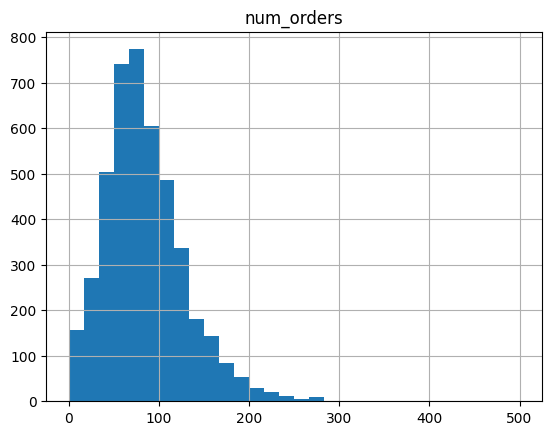

In [13]:
data.hist(bins=30, range = (0, 500));

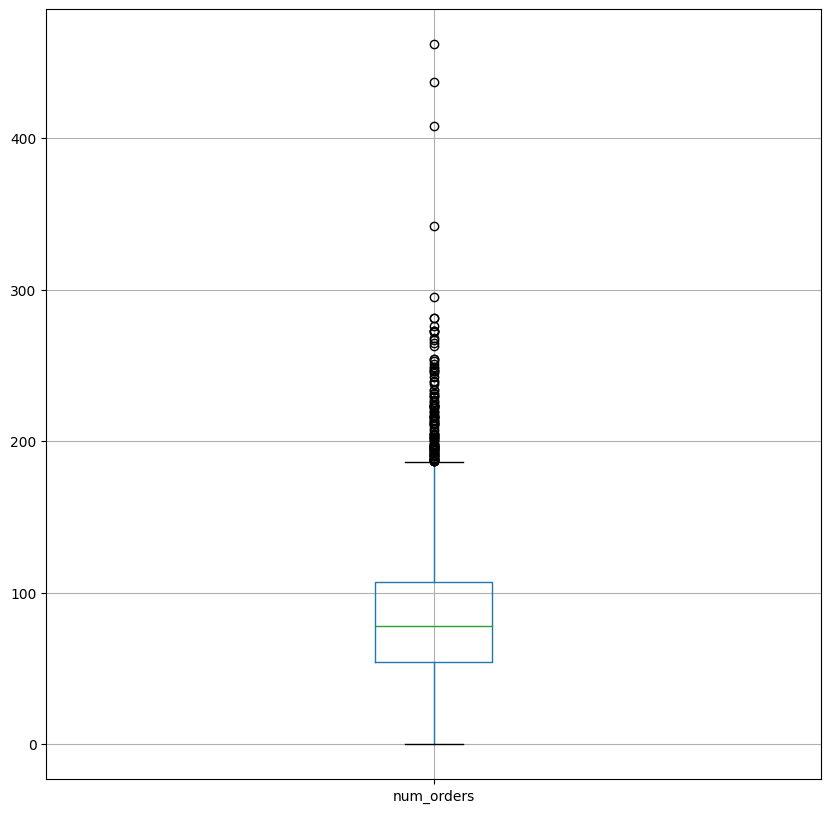

In [14]:
data.boxplot(figsize=(10,10));

In [15]:
data.index.min(), data.index.max() #index checking

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:00:00'))

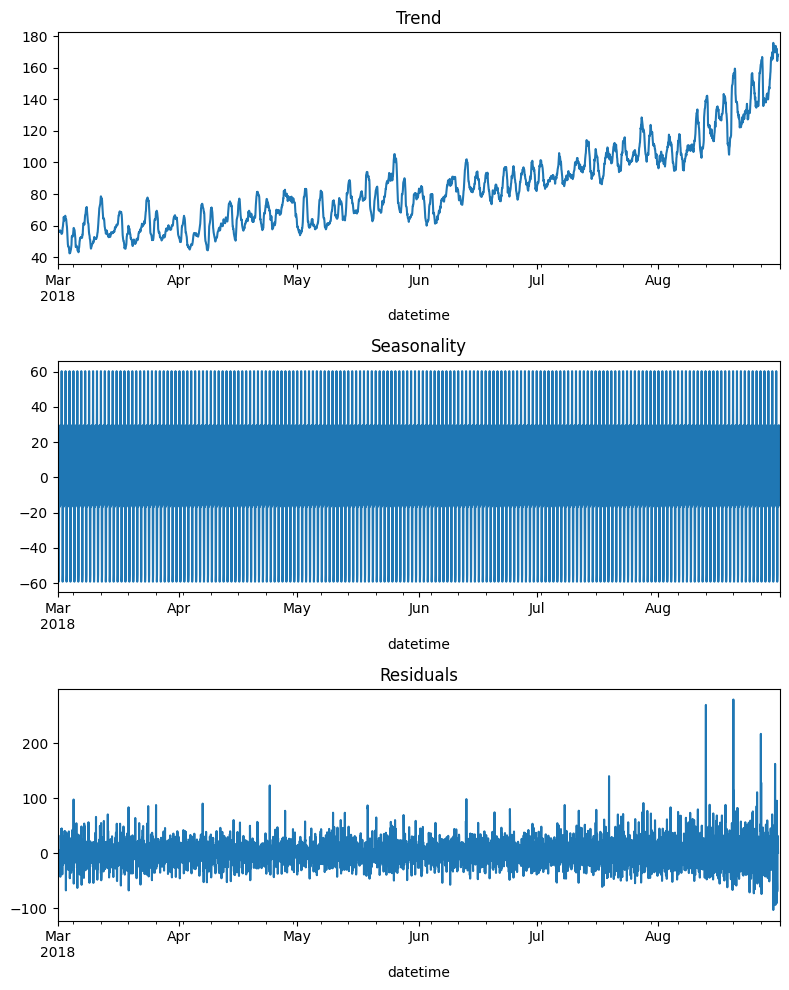

In [16]:
decomposed = seasonal_decompose(data) #decomposition

plt.figure(figsize=(8, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

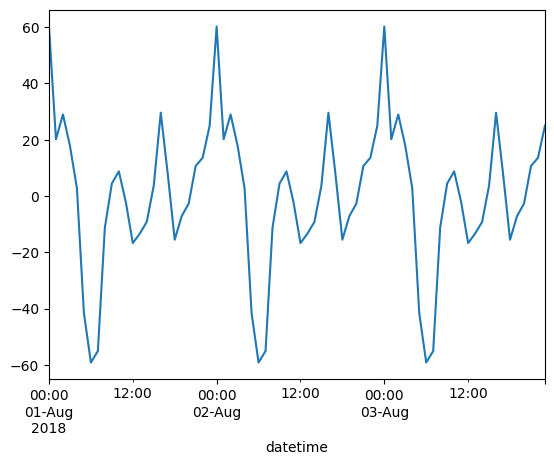

In [17]:
decomposed.seasonal['2018-08-01':'2018-08-3'].plot(); #Let's look separately at the seasonal component for several days in August

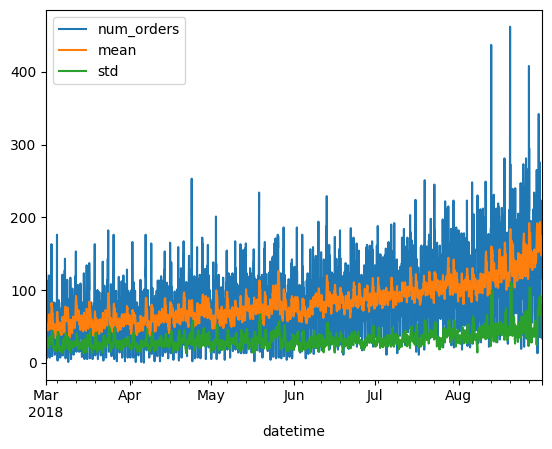

In [18]:
data['mean'] = data['num_orders'].rolling(15).mean() #adding a moving average to smooth the time series
data['std'] = data['num_orders'].rolling(15).std()
data.plot();

In [19]:
data_copy = data.copy()

In [20]:
data -= data.shift(fill_value=0) #let's calculate the differences in the time series so that we can make predictions

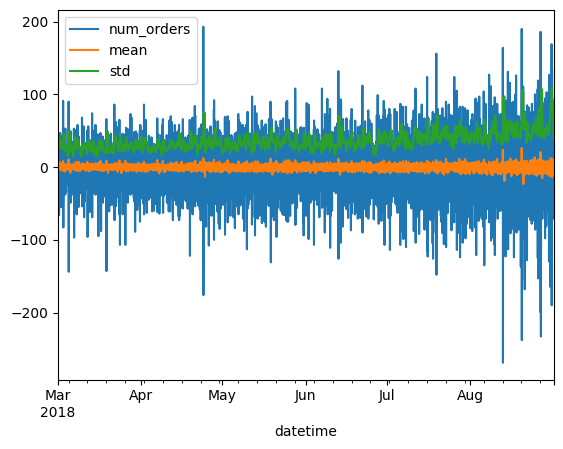

In [21]:
#Let's calculate the average and standard deviation on the new data

data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot();

After resampling the data at 1 hour intervals, there were 4416 rows left in the dataframe. No omissions were found during the analysis. Data on taxi orders are normally distributed, the average number of orders is about 84 per interval, the median value is 78. Values above about 180 orders are quite rare. The dates are in chronological order, from 2018-03-01 to 2018-08-31. 

We divided the data into a trend and a seasonal component, there is a trend - the number of orders begins to increase around the summer period, which is quite understandable - the holiday season is in full swing, and there is also the “hot” season in September-October for travelling. The number of taxi orders at night is not so large; their number is greater during the day. The series cannot be called stationary, since its mean changes over time. After subtracting the differences of the time series using the shift method, the series became more stationary and can now be predicted.

## Part 3. Training <a id='part3'></a>

In [22]:
#the function that adds four new features to the table with the original data: year, month, day and day of the week, lagging values, moving average

def make_features(data_copy, max_lag, rolling_mean_size):
    data_copy['year'] = data_copy.index.year
    data_copy['month'] = data_copy.index.month
    data_copy['day'] = data_copy.index.day
    data_copy['dayofweek'] = data_copy.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)

    data_copy['rolling_mean'] = data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data_copy, 10, 15)
print(data_copy.head())

                     num_orders  mean  std  year  month  day  dayofweek  \
datetime                                                                  
2018-03-01 00:00:00         124   NaN  NaN  2018      3    1          3   
2018-03-01 01:00:00          85   NaN  NaN  2018      3    1          3   
2018-03-01 02:00:00          71   NaN  NaN  2018      3    1          3   
2018-03-01 03:00:00          66   NaN  NaN  2018      3    1          3   
2018-03-01 04:00:00          43   NaN  NaN  2018      3    1          3   

                     lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  \
datetime                                                                      
2018-03-01 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-03-01 01:00:00  124.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-03-01 02:00:00   85.0  124.0    NaN    NaN    NaN    NaN    NaN    NaN   
2018-03-01 03:00:00   71.0   85.0  124.0    NaN    NaN    NaN    NaN    NaN   


In [23]:
#let's split the data into training and test data without shuffle, test size is 10 %

train, test = train_test_split(data_copy, shuffle=False, test_size=0.1)
print(train.index.min(), train.index.max()) #let's check if values follow chronological order
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [24]:
train = train.dropna() #let's drop nan that we got after adding new features

In [25]:
train.head()

,num_orders,mean,std,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 15:00:00,66,49.133333,27.357074,2018,3,1,3,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,53.000000
2018-03-01 16:00:00,43,46.333333,25.510969,2018,3,1,3,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,49.133333
2018-03-01 17:00:00,44,44.533333,24.581836,2018,3,1,3,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,46.333333
2018-03-01 18:00:00,73,45.000000,25.079872,2018,3,1,3,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,44.533333
2018-03-01 19:00:00,45,45.133333,25.073796,2018,3,1,3,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,45.000000


In [26]:
test.head()

,num_orders,mean,std,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,147.333333,97.130742,2018,8,13,0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,152.866667
2018-08-13 15:00:00,175,148.333333,97.347439,2018,8,13,0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,147.333333
2018-08-13 16:00:00,144,139.733333,91.041173,2018,8,13,0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,148.333333
2018-08-13 17:00:00,152,120.733333,40.006190,2018,8,13,0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,139.733333
2018-08-13 18:00:00,104,116.466667,37.965899,2018,8,13,0,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,120.733333


In [27]:
#let's split sets into target and features ones

target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

In [28]:
target_train.shape, features_train.shape, target_test.shape, features_test.shape

((3959,), (3959, 17), (442,), (442, 17))

In [29]:
#now we can use gridsearch to find the best linear regression parameters, 
#as well as random forest and lgbm regressor parameters

model_lin_reg = LinearRegression()
param_grid = {'fit_intercept': [True, False]} 

gs = GridSearchCV(estimator=model_lin_reg, param_grid = param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
gs.fit(features_train, target_train)

print(gs.best_score_)
print(gs.best_params_)
print(gs.best_estimator_)

-400.5058337288641
{'fit_intercept': False}
LinearRegression(fit_intercept=False)


In [30]:
model_lin_reg = gs.best_estimator_

model_lin_reg.fit(features_train, target_train)
print('RMSE of LinearRegression model:', math.sqrt(400.5058337288653))

RMSE of LinearRegression model: 20.01264184781373


In [31]:
#random forest

model_rand_forest = RandomForestRegressor(random_state = 12345, verbose = 15)
param_grid = {'n_estimators': [50, 75, 95]} 

gs = GridSearchCV(estimator=model_rand_forest, param_grid = param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
gs.fit(features_train, target_train)

print(gs.best_score_)
print(gs.best_params_)
print(gs.best_estimator_)

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.1s


building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50


[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    0.3s


building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.3s


building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50


[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50


[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    0.8s


building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    1.0s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50


[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    1.2s


building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50


[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.4s


building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50


[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    1.7s


building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50


[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.2s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50


[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.4s


building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50


[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.7s


building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50


[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50


[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    1.1s


building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50


[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    1.4s


building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50


[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    1.6s


building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50


[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    1.9s


building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50


[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    2.1s


building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50


[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    2.3s


building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50


[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    2.6s


building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50


[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.8s


building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50


[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.3s


building tree 4 of 50
building tree 5 of 50
building tree 6 of 50


[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.6s


building tree 7 of 50
building tree 8 of 50
building tree 9 of 50


[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.8s


building tree 10 of 50
building tree 11 of 50
building tree 12 of 50


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    1.0s


building tree 13 of 50
building tree 14 of 50
building tree 15 of 50


[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


building tree 16 of 50
building tree 17 of 50
building tree 18 of 50


[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    1.5s


building tree 19 of 50
building tree 20 of 50
building tree 21 of 50


[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    1.8s


building tree 22 of 50
building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    2.0s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50


[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    2.3s


building tree 28 of 50
building tree 29 of 50
building tree 30 of 50


[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    2.5s


building tree 31 of 50
building tree 32 of 50
building tree 33 of 50


[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    2.8s


building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    3.0s


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50


[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    3.3s


building tree 40 of 50
building tree 41 of 50
building tree 42 of 50


[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    3.6s


building tree 43 of 50
building tree 44 of 50
building tree 45 of 50


[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    3.8s


building tree 46 of 50
building tree 47 of 50
building tree 48 of 50


[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 49 of 50
building tree 50 of 50
building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s


building tree 2 of 50
building tree 3 of 50


[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.3s


building tree 4 of 50
building tree 5 of 50


[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.6s


building tree 6 of 50
building tree 7 of 50
building tree 8 of 50


[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.9s


building tree 9 of 50
building tree 10 of 50
building tree 11 of 50


[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    1.3s


building tree 12 of 50
building tree 13 of 50
building tree 14 of 50


[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    1.5s


building tree 15 of 50
building tree 16 of 50


[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    1.8s


building tree 17 of 50
building tree 18 of 50
building tree 19 of 50


[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    2.0s


building tree 20 of 50
building tree 21 of 50


[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    2.3s


building tree 22 of 50
building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    2.6s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50


[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    2.8s


building tree 28 of 50
building tree 29 of 50


[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    3.0s


building tree 30 of 50
building tree 31 of 50


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    3.3s


building tree 32 of 50
building tree 33 of 50
building tree 34 of 50


[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    3.6s


building tree 35 of 50
building tree 36 of 50
building tree 37 of 50


[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    3.9s


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    4.2s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50


[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    4.4s


building tree 44 of 50
building tree 45 of 50


[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    4.7s


building tree 46 of 50
building tree 47 of 50


[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.0s


building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    0.3s


building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75


[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    0.5s


building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75


[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.7s


building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75
building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75


[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  51 tasks      | elapsed:    0.9s


building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75
building tree 55 of 75
building tree 56 of 75


[Parallel(n_jobs=1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  53 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  54 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  55 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  57 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  58 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  59 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  61 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  62 tasks      | elapsed:    1.1s


building tree 57 of 75
building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75
building tree 66 of 75
building tree 67 of 75


[Parallel(n_jobs=1)]: Done  63 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  64 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  65 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  66 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  67 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  68 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  70 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  72 tasks      | elapsed:    1.3s


building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75
building tree 75 of 75


[Parallel(n_jobs=1)]: Done  73 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  74 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75


[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.2s


building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.4s


building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    0.6s


building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    0.9s


building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75


[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    1.1s


building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75


[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    1.4s


building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75


[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    1.6s


building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    1.8s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75


[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    2.0s


building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75
building tree 50 of 75


[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    2.2s


building tree 51 of 75
building tree 52 of 75
building tree 53 of 75
building tree 54 of 75


[Parallel(n_jobs=1)]: Done  51 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  53 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  54 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  55 tasks      | elapsed:    2.5s


building tree 55 of 75
building tree 56 of 75
building tree 57 of 75
building tree 58 of 75
building tree 59 of 75


[Parallel(n_jobs=1)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  57 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  58 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  59 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    2.7s


building tree 60 of 75
building tree 61 of 75
building tree 62 of 75
building tree 63 of 75
building tree 64 of 75


[Parallel(n_jobs=1)]: Done  61 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  62 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  63 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  64 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  65 tasks      | elapsed:    3.0s


building tree 65 of 75
building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75


[Parallel(n_jobs=1)]: Done  66 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done  67 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  68 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  69 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  70 tasks      | elapsed:    3.2s


building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75
building tree 74 of 75


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  72 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  73 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  74 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 75 of 75
building tree 1 of 75
building tree 2 of 75


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


building tree 3 of 75
building tree 4 of 75
building tree 5 of 75


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.3s


building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.5s


building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75


[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    1.0s


building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    1.2s


building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75


[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    1.5s


building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75


[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    1.7s


building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75


[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    2.0s


building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75


[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    2.2s


building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75


[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.5s


building tree 38 of 75
building tree 39 of 75
building tree 40 of 75
building tree 41 of 75


[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    2.7s


building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75


[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    3.0s


building tree 46 of 75
building tree 47 of 75
building tree 48 of 75
building tree 49 of 75


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  51 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  52 tasks      | elapsed:    3.3s


building tree 50 of 75
building tree 51 of 75
building tree 52 of 75
building tree 53 of 75


[Parallel(n_jobs=1)]: Done  53 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  54 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  55 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done  56 tasks      | elapsed:    3.5s


building tree 54 of 75
building tree 55 of 75
building tree 56 of 75
building tree 57 of 75


[Parallel(n_jobs=1)]: Done  57 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done  58 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done  59 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    3.8s


building tree 58 of 75
building tree 59 of 75
building tree 60 of 75
building tree 61 of 75


[Parallel(n_jobs=1)]: Done  61 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done  62 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done  63 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done  64 tasks      | elapsed:    4.0s


building tree 62 of 75
building tree 63 of 75
building tree 64 of 75
building tree 65 of 75


[Parallel(n_jobs=1)]: Done  65 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done  66 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done  67 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done  68 tasks      | elapsed:    4.2s


building tree 66 of 75
building tree 67 of 75
building tree 68 of 75
building tree 69 of 75


[Parallel(n_jobs=1)]: Done  69 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done  70 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done  72 tasks      | elapsed:    4.5s


building tree 70 of 75
building tree 71 of 75
building tree 72 of 75
building tree 73 of 75


[Parallel(n_jobs=1)]: Done  73 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done  74 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 74 of 75
building tree 75 of 75
building tree 1 of 75


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s


building tree 2 of 75
building tree 3 of 75
building tree 4 of 75


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.4s


building tree 5 of 75
building tree 6 of 75
building tree 7 of 75


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.6s


building tree 8 of 75
building tree 9 of 75
building tree 10 of 75


[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.9s


building tree 11 of 75
building tree 12 of 75
building tree 13 of 75


[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    1.1s


building tree 14 of 75
building tree 15 of 75
building tree 16 of 75


[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    1.4s


building tree 17 of 75
building tree 18 of 75
building tree 19 of 75


[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    1.6s


building tree 20 of 75
building tree 21 of 75
building tree 22 of 75


[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    1.9s


building tree 23 of 75
building tree 24 of 75
building tree 25 of 75


[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    2.1s


building tree 26 of 75
building tree 27 of 75
building tree 28 of 75


[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    2.4s


building tree 29 of 75
building tree 30 of 75
building tree 31 of 75


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    2.6s


building tree 32 of 75
building tree 33 of 75
building tree 34 of 75


[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    2.9s


building tree 35 of 75
building tree 36 of 75
building tree 37 of 75


[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    3.1s


building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    3.3s


building tree 41 of 75
building tree 42 of 75
building tree 43 of 75


[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    3.6s


building tree 44 of 75
building tree 45 of 75
building tree 46 of 75


[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    3.8s


building tree 47 of 75
building tree 48 of 75
building tree 49 of 75


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  51 tasks      | elapsed:    4.1s


building tree 50 of 75
building tree 51 of 75
building tree 52 of 75


[Parallel(n_jobs=1)]: Done  52 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done  53 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done  54 tasks      | elapsed:    4.4s


building tree 53 of 75
building tree 54 of 75
building tree 55 of 75


[Parallel(n_jobs=1)]: Done  55 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done  56 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done  57 tasks      | elapsed:    4.6s


building tree 56 of 75
building tree 57 of 75
building tree 58 of 75


[Parallel(n_jobs=1)]: Done  58 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done  59 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    4.9s


building tree 59 of 75
building tree 60 of 75
building tree 61 of 75


[Parallel(n_jobs=1)]: Done  61 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done  62 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done  63 tasks      | elapsed:    5.1s


building tree 62 of 75
building tree 63 of 75
building tree 64 of 75


[Parallel(n_jobs=1)]: Done  64 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done  65 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done  66 tasks      | elapsed:    5.3s


building tree 65 of 75
building tree 66 of 75
building tree 67 of 75


[Parallel(n_jobs=1)]: Done  67 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done  68 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done  69 tasks      | elapsed:    5.6s


building tree 68 of 75
building tree 69 of 75
building tree 70 of 75


[Parallel(n_jobs=1)]: Done  70 tasks      | elapsed:    5.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  72 tasks      | elapsed:    5.8s


building tree 71 of 75
building tree 72 of 75
building tree 73 of 75


[Parallel(n_jobs=1)]: Done  73 tasks      | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done  74 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 74 of 75
building tree 75 of 75
building tree 1 of 75


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s


building tree 2 of 75
building tree 3 of 75


[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.4s


building tree 4 of 75
building tree 5 of 75


[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.6s


building tree 6 of 75
building tree 7 of 75


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.8s


building tree 8 of 75
building tree 9 of 75


[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    1.1s


building tree 10 of 75
building tree 11 of 75
building tree 12 of 75


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    1.4s


building tree 13 of 75
building tree 14 of 75
building tree 15 of 75


[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    1.6s


building tree 16 of 75
building tree 17 of 75


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    1.8s


building tree 18 of 75
building tree 19 of 75


[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    2.1s


building tree 20 of 75
building tree 21 of 75


[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    2.3s


building tree 22 of 75
building tree 23 of 75


[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    2.6s


building tree 24 of 75
building tree 25 of 75
building tree 26 of 75


[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    2.8s


building tree 27 of 75
building tree 28 of 75


[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    3.1s


building tree 29 of 75
building tree 30 of 75
building tree 31 of 75


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    3.4s


building tree 32 of 75
building tree 33 of 75
building tree 34 of 75


[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    3.7s


building tree 35 of 75
building tree 36 of 75
building tree 37 of 75


[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    4.0s


building tree 38 of 75
building tree 39 of 75
building tree 40 of 75


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    4.3s


building tree 41 of 75
building tree 42 of 75


[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    4.6s


building tree 43 of 75
building tree 44 of 75
building tree 45 of 75


[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    4.8s


building tree 46 of 75
building tree 47 of 75


[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    5.0s


building tree 48 of 75
building tree 49 of 75


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    5.3s


building tree 50 of 75
building tree 51 of 75


[Parallel(n_jobs=1)]: Done  51 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done  52 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done  53 tasks      | elapsed:    5.6s


building tree 52 of 75
building tree 53 of 75
building tree 54 of 75


[Parallel(n_jobs=1)]: Done  54 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  55 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done  56 tasks      | elapsed:    5.9s


building tree 55 of 75
building tree 56 of 75
building tree 57 of 75


[Parallel(n_jobs=1)]: Done  57 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done  58 tasks      | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done  59 tasks      | elapsed:    6.2s


building tree 58 of 75
building tree 59 of 75
building tree 60 of 75


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done  61 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done  62 tasks      | elapsed:    6.5s


building tree 61 of 75
building tree 62 of 75
building tree 63 of 75


[Parallel(n_jobs=1)]: Done  63 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=1)]: Done  65 tasks      | elapsed:    6.8s


building tree 64 of 75
building tree 65 of 75
building tree 66 of 75


[Parallel(n_jobs=1)]: Done  66 tasks      | elapsed:    6.9s
[Parallel(n_jobs=1)]: Done  67 tasks      | elapsed:    7.0s


building tree 67 of 75
building tree 68 of 75


[Parallel(n_jobs=1)]: Done  68 tasks      | elapsed:    7.1s
[Parallel(n_jobs=1)]: Done  69 tasks      | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done  70 tasks      | elapsed:    7.4s


building tree 69 of 75
building tree 70 of 75
building tree 71 of 75


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    7.5s
[Parallel(n_jobs=1)]: Done  72 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Done  73 tasks      | elapsed:    7.7s


building tree 72 of 75
building tree 73 of 75
building tree 74 of 75


[Parallel(n_jobs=1)]: Done  74 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    7.9s
[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    7.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 75 of 75
building tree 1 of 95
building tree 2 of 95
building tree 3 of 95
building tree 4 of 95


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.2s


building tree 5 of 95
building tree 6 of 95
building tree 7 of 95
building tree 8 of 95
building tree 9 of 95
building tree 10 of 95
building tree 11 of 95
building tree 12 of 95
building tree 13 of 95
building tree 14 of 95
building tree 15 of 95


[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    0.4s


building tree 16 of 95
building tree 17 of 95
building tree 18 of 95
building tree 19 of 95
building tree 20 of 95
building tree 21 of 95
building tree 22 of 95
building tree 23 of 95
building tree 24 of 95


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    0.6s


building tree 25 of 95
building tree 26 of 95
building tree 27 of 95
building tree 28 of 95
building tree 29 of 95
building tree 30 of 95
building tree 31 of 95
building tree 32 of 95
building tree 33 of 95
building tree 34 of 95
building tree 35 of 95
building tree 36 of 95


[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    0.8s


building tree 37 of 95
building tree 38 of 95
building tree 39 of 95
building tree 40 of 95
building tree 41 of 95
building tree 42 of 95
building tree 43 of 95
building tree 44 of 95
building tree 45 of 95
building tree 46 of 95


[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  51 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  53 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  54 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  55 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  57 tasks      | elapsed:    1.1s


building tree 47 of 95
building tree 48 of 95
building tree 49 of 95
building tree 50 of 95
building tree 51 of 95
building tree 52 of 95
building tree 53 of 95
building tree 54 of 95
building tree 55 of 95
building tree 56 of 95
building tree 57 of 95
building tree 58 of 95


[Parallel(n_jobs=1)]: Done  58 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  59 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  61 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  62 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  63 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  64 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  65 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  66 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  67 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  68 tasks      | elapsed:    1.3s


building tree 59 of 95
building tree 60 of 95
building tree 61 of 95
building tree 62 of 95
building tree 63 of 95
building tree 64 of 95
building tree 65 of 95
building tree 66 of 95
building tree 67 of 95
building tree 68 of 95
building tree 69 of 95


[Parallel(n_jobs=1)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  70 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  73 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  74 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  77 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  78 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  79 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  80 tasks      | elapsed:    1.5s


building tree 70 of 95
building tree 71 of 95
building tree 72 of 95
building tree 73 of 95
building tree 74 of 95
building tree 75 of 95
building tree 76 of 95
building tree 77 of 95
building tree 78 of 95
building tree 79 of 95
building tree 80 of 95
building tree 81 of 95


[Parallel(n_jobs=1)]: Done  81 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  82 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  83 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  85 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  86 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  87 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  88 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  89 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  90 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  91 tasks      | elapsed:    1.7s


building tree 82 of 95
building tree 83 of 95
building tree 84 of 95
building tree 85 of 95
building tree 86 of 95
building tree 87 of 95
building tree 88 of 95
building tree 89 of 95
building tree 90 of 95
building tree 91 of 95
building tree 92 of 95


[Parallel(n_jobs=1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  93 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  94 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 93 of 95
building tree 94 of 95
building tree 95 of 95
building tree 1 of 95
building tree 2 of 95
building tree 3 of 95


[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.2s


building tree 4 of 95
building tree 5 of 95
building tree 6 of 95
building tree 7 of 95
building tree 8 of 95
building tree 9 of 95


[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.5s


building tree 10 of 95
building tree 11 of 95
building tree 12 of 95
building tree 13 of 95
building tree 14 of 95
building tree 15 of 95


[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    0.7s


building tree 16 of 95
building tree 17 of 95
building tree 18 of 95
building tree 19 of 95
building tree 20 of 95
building tree 21 of 95


[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    0.9s


building tree 22 of 95
building tree 23 of 95
building tree 24 of 95
building tree 25 of 95
building tree 26 of 95
building tree 27 of 95


[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    1.2s


building tree 28 of 95
building tree 29 of 95
building tree 30 of 95
building tree 31 of 95
building tree 32 of 95
building tree 33 of 95


[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    1.4s


building tree 34 of 95
building tree 35 of 95
building tree 36 of 95
building tree 37 of 95
building tree 38 of 95
building tree 39 of 95


[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    1.6s


building tree 40 of 95
building tree 41 of 95
building tree 42 of 95
building tree 43 of 95
building tree 44 of 95
building tree 45 of 95


[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    1.9s


building tree 46 of 95
building tree 47 of 95
building tree 48 of 95
building tree 49 of 95
building tree 50 of 95
building tree 51 of 95


[Parallel(n_jobs=1)]: Done  51 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  53 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  54 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  55 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  56 tasks      | elapsed:    2.1s


building tree 52 of 95
building tree 53 of 95
building tree 54 of 95
building tree 55 of 95
building tree 56 of 95
building tree 57 of 95


[Parallel(n_jobs=1)]: Done  57 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  58 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  59 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  61 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  62 tasks      | elapsed:    2.3s


building tree 58 of 95
building tree 59 of 95
building tree 60 of 95
building tree 61 of 95
building tree 62 of 95
building tree 63 of 95


[Parallel(n_jobs=1)]: Done  63 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  64 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  65 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  66 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  67 tasks      | elapsed:    2.6s


building tree 64 of 95
building tree 65 of 95
building tree 66 of 95
building tree 67 of 95
building tree 68 of 95


[Parallel(n_jobs=1)]: Done  68 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  69 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  70 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  72 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  73 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  74 tasks      | elapsed:    2.8s


building tree 69 of 95
building tree 70 of 95
building tree 71 of 95
building tree 72 of 95
building tree 73 of 95
building tree 74 of 95
building tree 75 of 95


[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  77 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  78 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done  79 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done  80 tasks      | elapsed:    3.0s


building tree 76 of 95
building tree 77 of 95
building tree 78 of 95
building tree 79 of 95
building tree 80 of 95
building tree 81 of 95


[Parallel(n_jobs=1)]: Done  81 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  82 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  83 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  85 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  86 tasks      | elapsed:    3.3s


building tree 82 of 95
building tree 83 of 95
building tree 84 of 95
building tree 85 of 95
building tree 86 of 95
building tree 87 of 95


[Parallel(n_jobs=1)]: Done  87 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  88 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  89 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  90 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  91 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done  92 tasks      | elapsed:    3.5s


building tree 88 of 95
building tree 89 of 95
building tree 90 of 95
building tree 91 of 95
building tree 92 of 95
building tree 93 of 95


[Parallel(n_jobs=1)]: Done  93 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done  94 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 94 of 95
building tree 95 of 95
building tree 1 of 95
building tree 2 of 95


[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.2s


building tree 3 of 95
building tree 4 of 95
building tree 5 of 95
building tree 6 of 95


[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.4s


building tree 7 of 95
building tree 8 of 95
building tree 9 of 95
building tree 10 of 95


[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.7s


building tree 11 of 95
building tree 12 of 95
building tree 13 of 95
building tree 14 of 95


[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


building tree 15 of 95
building tree 16 of 95
building tree 17 of 95
building tree 18 of 95


[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    1.2s


building tree 19 of 95
building tree 20 of 95
building tree 21 of 95
building tree 22 of 95


[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    1.4s


building tree 23 of 95
building tree 24 of 95
building tree 25 of 95
building tree 26 of 95


[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    1.6s


building tree 27 of 95
building tree 28 of 95
building tree 29 of 95
building tree 30 of 95


[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    1.9s


building tree 31 of 95
building tree 32 of 95
building tree 33 of 95
building tree 34 of 95


[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    2.1s


building tree 35 of 95
building tree 36 of 95
building tree 37 of 95
building tree 38 of 95


[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    2.4s


building tree 39 of 95
building tree 40 of 95
building tree 41 of 95
building tree 42 of 95


[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    2.6s


building tree 43 of 95
building tree 44 of 95
building tree 45 of 95
building tree 46 of 95


[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.8s


building tree 47 of 95
building tree 48 of 95
building tree 49 of 95
building tree 50 of 95


[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  51 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done  52 tasks      | elapsed:    3.1s


building tree 51 of 95
building tree 52 of 95
building tree 53 of 95


[Parallel(n_jobs=1)]: Done  53 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  54 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  55 tasks      | elapsed:    3.3s


building tree 54 of 95
building tree 55 of 95
building tree 56 of 95


[Parallel(n_jobs=1)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  57 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  58 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done  59 tasks      | elapsed:    3.5s


building tree 57 of 95
building tree 58 of 95
building tree 59 of 95
building tree 60 of 95


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done  61 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done  62 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done  63 tasks      | elapsed:    3.8s


building tree 61 of 95
building tree 62 of 95
building tree 63 of 95
building tree 64 of 95


[Parallel(n_jobs=1)]: Done  64 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done  65 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done  66 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  67 tasks      | elapsed:    4.0s


building tree 65 of 95
building tree 66 of 95
building tree 67 of 95
building tree 68 of 95


[Parallel(n_jobs=1)]: Done  68 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done  69 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done  70 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.3s


building tree 69 of 95
building tree 70 of 95
building tree 71 of 95
building tree 72 of 95


[Parallel(n_jobs=1)]: Done  72 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done  73 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done  74 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    4.5s


building tree 73 of 95
building tree 74 of 95
building tree 75 of 95
building tree 76 of 95


[Parallel(n_jobs=1)]: Done  76 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done  77 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done  78 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done  79 tasks      | elapsed:    4.7s


building tree 77 of 95
building tree 78 of 95
building tree 79 of 95
building tree 80 of 95


[Parallel(n_jobs=1)]: Done  80 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  81 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  82 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done  83 tasks      | elapsed:    5.0s


building tree 81 of 95
building tree 82 of 95
building tree 83 of 95
building tree 84 of 95


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done  85 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done  86 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done  87 tasks      | elapsed:    5.2s


building tree 85 of 95
building tree 86 of 95
building tree 87 of 95
building tree 88 of 95


[Parallel(n_jobs=1)]: Done  88 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done  89 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done  90 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done  91 tasks      | elapsed:    5.4s


building tree 89 of 95
building tree 90 of 95
building tree 91 of 95
building tree 92 of 95


[Parallel(n_jobs=1)]: Done  92 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done  93 tasks      | elapsed:    5.6s
[Parallel(n_jobs=1)]: Done  94 tasks      | elapsed:    5.6s
[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 93 of 95
building tree 94 of 95
building tree 95 of 95
building tree 1 of 95


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


building tree 2 of 95
building tree 3 of 95
building tree 4 of 95


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.4s


building tree 5 of 95
building tree 6 of 95
building tree 7 of 95


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.6s


building tree 8 of 95
building tree 9 of 95
building tree 10 of 95


[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.9s


building tree 11 of 95
building tree 12 of 95
building tree 13 of 95


[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    1.1s


building tree 14 of 95
building tree 15 of 95
building tree 16 of 95


[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    1.4s


building tree 17 of 95
building tree 18 of 95
building tree 19 of 95


[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    1.6s


building tree 20 of 95
building tree 21 of 95
building tree 22 of 95


[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    1.9s


building tree 23 of 95
building tree 24 of 95
building tree 25 of 95


[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    2.1s


building tree 26 of 95
building tree 27 of 95
building tree 28 of 95


[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    2.4s


building tree 29 of 95
building tree 30 of 95
building tree 31 of 95


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    2.6s


building tree 32 of 95
building tree 33 of 95
building tree 34 of 95


[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    2.9s


building tree 35 of 95
building tree 36 of 95
building tree 37 of 95


[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    3.1s


building tree 38 of 95
building tree 39 of 95
building tree 40 of 95


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    3.4s


building tree 41 of 95
building tree 42 of 95
building tree 43 of 95


[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    3.6s


building tree 44 of 95
building tree 45 of 95
building tree 46 of 95


[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    3.9s


building tree 47 of 95
building tree 48 of 95
building tree 49 of 95


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  51 tasks      | elapsed:    4.1s


building tree 50 of 95
building tree 51 of 95
building tree 52 of 95


[Parallel(n_jobs=1)]: Done  52 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done  53 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done  54 tasks      | elapsed:    4.4s


building tree 53 of 95
building tree 54 of 95
building tree 55 of 95


[Parallel(n_jobs=1)]: Done  55 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done  56 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done  57 tasks      | elapsed:    4.6s


building tree 56 of 95
building tree 57 of 95
building tree 58 of 95


[Parallel(n_jobs=1)]: Done  58 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done  59 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    4.9s


building tree 59 of 95
building tree 60 of 95
building tree 61 of 95


[Parallel(n_jobs=1)]: Done  61 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done  62 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done  63 tasks      | elapsed:    5.1s


building tree 62 of 95
building tree 63 of 95
building tree 64 of 95


[Parallel(n_jobs=1)]: Done  64 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done  65 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done  66 tasks      | elapsed:    5.3s


building tree 65 of 95
building tree 66 of 95
building tree 67 of 95


[Parallel(n_jobs=1)]: Done  67 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done  68 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done  69 tasks      | elapsed:    5.6s


building tree 68 of 95
building tree 69 of 95
building tree 70 of 95


[Parallel(n_jobs=1)]: Done  70 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done  72 tasks      | elapsed:    5.9s


building tree 71 of 95
building tree 72 of 95
building tree 73 of 95


[Parallel(n_jobs=1)]: Done  73 tasks      | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done  74 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    6.1s


building tree 74 of 95
building tree 75 of 95
building tree 76 of 95


[Parallel(n_jobs=1)]: Done  76 tasks      | elapsed:    6.2s
[Parallel(n_jobs=1)]: Done  77 tasks      | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done  78 tasks      | elapsed:    6.4s


building tree 77 of 95
building tree 78 of 95
building tree 79 of 95


[Parallel(n_jobs=1)]: Done  79 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done  80 tasks      | elapsed:    6.5s
[Parallel(n_jobs=1)]: Done  81 tasks      | elapsed:    6.6s


building tree 80 of 95
building tree 81 of 95
building tree 82 of 95


[Parallel(n_jobs=1)]: Done  82 tasks      | elapsed:    6.7s
[Parallel(n_jobs=1)]: Done  83 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    6.9s


building tree 83 of 95
building tree 84 of 95
building tree 85 of 95


[Parallel(n_jobs=1)]: Done  85 tasks      | elapsed:    6.9s
[Parallel(n_jobs=1)]: Done  86 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done  87 tasks      | elapsed:    7.1s


building tree 86 of 95
building tree 87 of 95
building tree 88 of 95


[Parallel(n_jobs=1)]: Done  88 tasks      | elapsed:    7.2s
[Parallel(n_jobs=1)]: Done  89 tasks      | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done  90 tasks      | elapsed:    7.3s


building tree 89 of 95
building tree 90 of 95
building tree 91 of 95


[Parallel(n_jobs=1)]: Done  91 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  92 tasks      | elapsed:    7.5s
[Parallel(n_jobs=1)]: Done  93 tasks      | elapsed:    7.6s


building tree 92 of 95
building tree 93 of 95
building tree 94 of 95


[Parallel(n_jobs=1)]: Done  94 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 95 of 95
building tree 1 of 95


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s


building tree 2 of 95
building tree 3 of 95
building tree 4 of 95


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.4s


building tree 5 of 95
building tree 6 of 95


[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.6s


building tree 7 of 95
building tree 8 of 95


[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.9s


building tree 9 of 95
building tree 10 of 95


[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    1.1s


building tree 11 of 95
building tree 12 of 95


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    1.4s


building tree 13 of 95
building tree 14 of 95
building tree 15 of 95


[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    1.6s


building tree 16 of 95
building tree 17 of 95


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    1.8s


building tree 18 of 95
building tree 19 of 95


[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    2.0s


building tree 20 of 95
building tree 21 of 95


[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    2.3s


building tree 22 of 95
building tree 23 of 95
building tree 24 of 95


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    2.7s


building tree 25 of 95
building tree 26 of 95
building tree 27 of 95


[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    2.9s


building tree 28 of 95
building tree 29 of 95


[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    3.1s


building tree 30 of 95
building tree 31 of 95


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    3.4s


building tree 32 of 95
building tree 33 of 95
building tree 34 of 95


[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    3.7s


building tree 35 of 95
building tree 36 of 95


[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    3.9s


building tree 37 of 95
building tree 38 of 95


[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    4.1s


building tree 39 of 95
building tree 40 of 95


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    4.3s


building tree 41 of 95
building tree 42 of 95


[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    4.7s


building tree 43 of 95
building tree 44 of 95
building tree 45 of 95


[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    5.0s


building tree 46 of 95
building tree 47 of 95
building tree 48 of 95


[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    5.3s


building tree 49 of 95
building tree 50 of 95
building tree 51 of 95


[Parallel(n_jobs=1)]: Done  51 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done  52 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done  53 tasks      | elapsed:    5.6s


building tree 52 of 95
building tree 53 of 95
building tree 54 of 95


[Parallel(n_jobs=1)]: Done  54 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  55 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done  56 tasks      | elapsed:    5.9s


building tree 55 of 95
building tree 56 of 95
building tree 57 of 95


[Parallel(n_jobs=1)]: Done  57 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done  58 tasks      | elapsed:    6.1s


building tree 58 of 95
building tree 59 of 95


[Parallel(n_jobs=1)]: Done  59 tasks      | elapsed:    6.2s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    6.3s


building tree 60 of 95
building tree 61 of 95


[Parallel(n_jobs=1)]: Done  61 tasks      | elapsed:    6.5s
[Parallel(n_jobs=1)]: Done  62 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done  63 tasks      | elapsed:    6.7s


building tree 62 of 95
building tree 63 of 95
building tree 64 of 95


[Parallel(n_jobs=1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done  65 tasks      | elapsed:    6.9s


building tree 65 of 95
building tree 66 of 95


[Parallel(n_jobs=1)]: Done  66 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done  67 tasks      | elapsed:    7.1s
[Parallel(n_jobs=1)]: Done  68 tasks      | elapsed:    7.2s


building tree 67 of 95
building tree 68 of 95
building tree 69 of 95


[Parallel(n_jobs=1)]: Done  69 tasks      | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done  70 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    7.5s


building tree 70 of 95
building tree 71 of 95
building tree 72 of 95


[Parallel(n_jobs=1)]: Done  72 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Done  73 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done  74 tasks      | elapsed:    7.8s


building tree 73 of 95
building tree 74 of 95
building tree 75 of 95


[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    7.9s
[Parallel(n_jobs=1)]: Done  76 tasks      | elapsed:    8.0s
[Parallel(n_jobs=1)]: Done  77 tasks      | elapsed:    8.1s


building tree 76 of 95
building tree 77 of 95
building tree 78 of 95


[Parallel(n_jobs=1)]: Done  78 tasks      | elapsed:    8.2s
[Parallel(n_jobs=1)]: Done  79 tasks      | elapsed:    8.3s


building tree 79 of 95
building tree 80 of 95


[Parallel(n_jobs=1)]: Done  80 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done  81 tasks      | elapsed:    8.6s


building tree 81 of 95
building tree 82 of 95


[Parallel(n_jobs=1)]: Done  82 tasks      | elapsed:    8.7s
[Parallel(n_jobs=1)]: Done  83 tasks      | elapsed:    8.8s


building tree 83 of 95
building tree 84 of 95


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    8.9s
[Parallel(n_jobs=1)]: Done  85 tasks      | elapsed:    9.0s


building tree 85 of 95
building tree 86 of 95


[Parallel(n_jobs=1)]: Done  86 tasks      | elapsed:    9.1s
[Parallel(n_jobs=1)]: Done  87 tasks      | elapsed:    9.2s


building tree 87 of 95
building tree 88 of 95


[Parallel(n_jobs=1)]: Done  88 tasks      | elapsed:    9.3s
[Parallel(n_jobs=1)]: Done  89 tasks      | elapsed:    9.4s


building tree 89 of 95
building tree 90 of 95


[Parallel(n_jobs=1)]: Done  90 tasks      | elapsed:    9.5s
[Parallel(n_jobs=1)]: Done  91 tasks      | elapsed:    9.6s


building tree 91 of 95
building tree 92 of 95


[Parallel(n_jobs=1)]: Done  92 tasks      | elapsed:    9.7s
[Parallel(n_jobs=1)]: Done  93 tasks      | elapsed:    9.8s
[Parallel(n_jobs=1)]: Done  94 tasks      | elapsed:    9.9s


building tree 93 of 95
building tree 94 of 95
building tree 95 of 95


[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:   10.0s
[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:   10.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

building tree 1 of 95
building tree 2 of 95


[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s


building tree 3 of 95
building tree 4 of 95


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.6s


building tree 5 of 95
building tree 6 of 95


[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.8s


building tree 7 of 95
building tree 8 of 95


[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    1.1s


building tree 9 of 95
building tree 10 of 95


[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    1.3s


building tree 11 of 95
building tree 12 of 95


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    1.6s


building tree 13 of 95
building tree 14 of 95


[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    1.8s


building tree 15 of 95
building tree 16 of 95


[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s


building tree 17 of 95
building tree 18 of 95


[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    2.4s


building tree 19 of 95
building tree 20 of 95


[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    2.6s


building tree 21 of 95
building tree 22 of 95


[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    2.9s


building tree 23 of 95
building tree 24 of 95


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    3.1s


building tree 25 of 95
building tree 26 of 95


[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    3.4s


building tree 27 of 95
building tree 28 of 95


[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    3.7s


building tree 29 of 95
building tree 30 of 95


[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    3.9s


building tree 31 of 95
building tree 32 of 95


[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    4.2s


building tree 33 of 95
building tree 34 of 95


[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    4.4s


building tree 35 of 95
building tree 36 of 95


[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    4.7s


building tree 37 of 95
building tree 38 of 95


[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    5.0s


building tree 39 of 95
building tree 40 of 95


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    5.2s


building tree 41 of 95
building tree 42 of 95


[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    5.4s


building tree 43 of 95
building tree 44 of 95


[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    5.6s
[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    5.7s


building tree 45 of 95
building tree 46 of 95


[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    6.0s


building tree 47 of 95
building tree 48 of 95


[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.2s


building tree 49 of 95
building tree 50 of 95


[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done  51 tasks      | elapsed:    6.5s


building tree 51 of 95
building tree 52 of 95


[Parallel(n_jobs=1)]: Done  52 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done  53 tasks      | elapsed:    6.8s


building tree 53 of 95
building tree 54 of 95


[Parallel(n_jobs=1)]: Done  54 tasks      | elapsed:    6.9s
[Parallel(n_jobs=1)]: Done  55 tasks      | elapsed:    7.0s


building tree 55 of 95
building tree 56 of 95


[Parallel(n_jobs=1)]: Done  56 tasks      | elapsed:    7.1s
[Parallel(n_jobs=1)]: Done  57 tasks      | elapsed:    7.3s


building tree 57 of 95
building tree 58 of 95


[Parallel(n_jobs=1)]: Done  58 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  59 tasks      | elapsed:    7.5s


building tree 59 of 95
building tree 60 of 95


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Done  61 tasks      | elapsed:    7.8s


building tree 61 of 95
building tree 62 of 95


[Parallel(n_jobs=1)]: Done  62 tasks      | elapsed:    7.9s
[Parallel(n_jobs=1)]: Done  63 tasks      | elapsed:    8.0s


building tree 63 of 95
building tree 64 of 95


[Parallel(n_jobs=1)]: Done  64 tasks      | elapsed:    8.1s
[Parallel(n_jobs=1)]: Done  65 tasks      | elapsed:    8.3s


building tree 65 of 95
building tree 66 of 95


[Parallel(n_jobs=1)]: Done  66 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done  67 tasks      | elapsed:    8.5s


building tree 67 of 95
building tree 68 of 95


[Parallel(n_jobs=1)]: Done  68 tasks      | elapsed:    8.7s
[Parallel(n_jobs=1)]: Done  69 tasks      | elapsed:    8.8s


building tree 69 of 95
building tree 70 of 95


[Parallel(n_jobs=1)]: Done  70 tasks      | elapsed:    8.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    9.0s


building tree 71 of 95
building tree 72 of 95


[Parallel(n_jobs=1)]: Done  72 tasks      | elapsed:    9.2s
[Parallel(n_jobs=1)]: Done  73 tasks      | elapsed:    9.3s


building tree 73 of 95
building tree 74 of 95


[Parallel(n_jobs=1)]: Done  74 tasks      | elapsed:    9.4s
[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:    9.5s


building tree 75 of 95
building tree 76 of 95


[Parallel(n_jobs=1)]: Done  76 tasks      | elapsed:    9.7s
[Parallel(n_jobs=1)]: Done  77 tasks      | elapsed:    9.8s


building tree 77 of 95
building tree 78 of 95


[Parallel(n_jobs=1)]: Done  78 tasks      | elapsed:    9.9s
[Parallel(n_jobs=1)]: Done  79 tasks      | elapsed:   10.0s


building tree 79 of 95
building tree 80 of 95


[Parallel(n_jobs=1)]: Done  80 tasks      | elapsed:   10.2s
[Parallel(n_jobs=1)]: Done  81 tasks      | elapsed:   10.3s


building tree 81 of 95
building tree 82 of 95


[Parallel(n_jobs=1)]: Done  82 tasks      | elapsed:   10.4s
[Parallel(n_jobs=1)]: Done  83 tasks      | elapsed:   10.5s


building tree 83 of 95
building tree 84 of 95


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:   10.7s
[Parallel(n_jobs=1)]: Done  85 tasks      | elapsed:   10.8s


building tree 85 of 95
building tree 86 of 95


[Parallel(n_jobs=1)]: Done  86 tasks      | elapsed:   10.9s
[Parallel(n_jobs=1)]: Done  87 tasks      | elapsed:   11.1s


building tree 87 of 95
building tree 88 of 95


[Parallel(n_jobs=1)]: Done  88 tasks      | elapsed:   11.2s
[Parallel(n_jobs=1)]: Done  89 tasks      | elapsed:   11.3s


building tree 89 of 95
building tree 90 of 95


[Parallel(n_jobs=1)]: Done  90 tasks      | elapsed:   11.4s
[Parallel(n_jobs=1)]: Done  91 tasks      | elapsed:   11.5s


building tree 91 of 95
building tree 92 of 95


[Parallel(n_jobs=1)]: Done  92 tasks      | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done  93 tasks      | elapsed:   11.8s


building tree 93 of 95
building tree 94 of 95
building tree 95 of 95
-736.378535496156
{'n_estimators': 95}
RandomForestRegressor(n_estimators=95, random_state=12345, verbose=15)


[Parallel(n_jobs=1)]: Done  94 tasks      | elapsed:   11.9s
[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:   12.1s
[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:   12.1s


In [32]:
model_rand_forest = gs.best_estimator_
model_rand_forest.fit(features_train, target_train)
print('RMSE of RandomForestRegressor model:', math.sqrt(736.378535496156))

building tree 1 of 95
building tree 2 of 95


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s


building tree 3 of 95
building tree 4 of 95


[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.5s


building tree 5 of 95
building tree 6 of 95


[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.7s


building tree 7 of 95
building tree 8 of 95


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    1.0s


building tree 9 of 95
building tree 10 of 95


[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    1.3s


building tree 11 of 95
building tree 12 of 95


[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    1.5s


building tree 13 of 95
building tree 14 of 95


[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    1.8s


building tree 15 of 95
building tree 16 of 95


[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    2.1s


building tree 17 of 95
building tree 18 of 95


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    2.4s


building tree 19 of 95
building tree 20 of 95


[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    2.7s


building tree 21 of 95
building tree 22 of 95


[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    3.0s


building tree 23 of 95
building tree 24 of 95


[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    3.2s


building tree 25 of 95
building tree 26 of 95


[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    3.5s


building tree 27 of 95
building tree 28 of 95


[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    3.8s


building tree 29 of 95
building tree 30 of 95


[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    4.1s


building tree 31 of 95
building tree 32 of 95


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    4.4s


building tree 33 of 95
building tree 34 of 95


[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    4.7s


building tree 35 of 95
building tree 36 of 95


[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    5.0s


building tree 37 of 95
building tree 38 of 95


[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    5.3s


building tree 39 of 95
building tree 40 of 95


[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.6s


building tree 41 of 95
building tree 42 of 95


[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    5.8s


building tree 43 of 95
building tree 44 of 95


[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    6.1s


building tree 45 of 95
building tree 46 of 95


[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    6.2s
[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    6.4s


building tree 47 of 95
building tree 48 of 95


[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    6.5s
[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    6.6s


building tree 49 of 95
building tree 50 of 95


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    6.9s


building tree 51 of 95
building tree 52 of 95


[Parallel(n_jobs=1)]: Done  51 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done  52 tasks      | elapsed:    7.2s


building tree 53 of 95
building tree 54 of 95


[Parallel(n_jobs=1)]: Done  53 tasks      | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done  54 tasks      | elapsed:    7.4s


building tree 55 of 95
building tree 56 of 95


[Parallel(n_jobs=1)]: Done  55 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Done  56 tasks      | elapsed:    7.7s


building tree 57 of 95
building tree 58 of 95


[Parallel(n_jobs=1)]: Done  57 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done  58 tasks      | elapsed:    8.0s


building tree 59 of 95
building tree 60 of 95


[Parallel(n_jobs=1)]: Done  59 tasks      | elapsed:    8.1s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    8.2s


building tree 61 of 95
building tree 62 of 95


[Parallel(n_jobs=1)]: Done  61 tasks      | elapsed:    8.3s
[Parallel(n_jobs=1)]: Done  62 tasks      | elapsed:    8.5s


building tree 63 of 95
building tree 64 of 95


[Parallel(n_jobs=1)]: Done  63 tasks      | elapsed:    8.6s
[Parallel(n_jobs=1)]: Done  64 tasks      | elapsed:    8.7s


building tree 65 of 95
building tree 66 of 95


[Parallel(n_jobs=1)]: Done  65 tasks      | elapsed:    8.9s
[Parallel(n_jobs=1)]: Done  66 tasks      | elapsed:    9.0s


building tree 67 of 95
building tree 68 of 95


[Parallel(n_jobs=1)]: Done  67 tasks      | elapsed:    9.1s
[Parallel(n_jobs=1)]: Done  68 tasks      | elapsed:    9.2s


building tree 69 of 95
building tree 70 of 95


[Parallel(n_jobs=1)]: Done  69 tasks      | elapsed:    9.4s
[Parallel(n_jobs=1)]: Done  70 tasks      | elapsed:    9.5s


building tree 71 of 95
building tree 72 of 95


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    9.6s
[Parallel(n_jobs=1)]: Done  72 tasks      | elapsed:    9.7s


building tree 73 of 95
building tree 74 of 95


[Parallel(n_jobs=1)]: Done  73 tasks      | elapsed:    9.9s
[Parallel(n_jobs=1)]: Done  74 tasks      | elapsed:   10.0s


building tree 75 of 95
building tree 76 of 95


[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done  76 tasks      | elapsed:   10.2s


building tree 77 of 95
building tree 78 of 95


[Parallel(n_jobs=1)]: Done  77 tasks      | elapsed:   10.4s
[Parallel(n_jobs=1)]: Done  78 tasks      | elapsed:   10.5s


building tree 79 of 95
building tree 80 of 95


[Parallel(n_jobs=1)]: Done  79 tasks      | elapsed:   10.6s
[Parallel(n_jobs=1)]: Done  80 tasks      | elapsed:   10.8s


building tree 81 of 95
building tree 82 of 95


[Parallel(n_jobs=1)]: Done  81 tasks      | elapsed:   10.9s
[Parallel(n_jobs=1)]: Done  82 tasks      | elapsed:   11.0s


building tree 83 of 95
building tree 84 of 95


[Parallel(n_jobs=1)]: Done  83 tasks      | elapsed:   11.2s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:   11.3s


building tree 85 of 95
building tree 86 of 95


[Parallel(n_jobs=1)]: Done  85 tasks      | elapsed:   11.4s
[Parallel(n_jobs=1)]: Done  86 tasks      | elapsed:   11.5s


building tree 87 of 95
building tree 88 of 95


[Parallel(n_jobs=1)]: Done  87 tasks      | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done  88 tasks      | elapsed:   11.8s


building tree 89 of 95
building tree 90 of 95


[Parallel(n_jobs=1)]: Done  89 tasks      | elapsed:   11.9s
[Parallel(n_jobs=1)]: Done  90 tasks      | elapsed:   12.0s


building tree 91 of 95
building tree 92 of 95


[Parallel(n_jobs=1)]: Done  91 tasks      | elapsed:   12.1s
[Parallel(n_jobs=1)]: Done  92 tasks      | elapsed:   12.3s


building tree 93 of 95
building tree 94 of 95


[Parallel(n_jobs=1)]: Done  93 tasks      | elapsed:   12.4s
[Parallel(n_jobs=1)]: Done  94 tasks      | elapsed:   12.5s


building tree 95 of 95
RMSE of RandomForestRegressor model: 27.13629553745603


[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:   12.6s
[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:   12.6s


In [33]:
#lgbmregressor

model_lgbm = lgb.LGBMRegressor()

param_grid = {
              'learning_rate': [0.1, 1], 
              'max_depth': [10, 16],
              'num_leaves': [2, 31]
             } 

grid = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', refit = True, verbose = 15)
grid.fit(features_train, target_train)

print(gs.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START learning_rate=0.1, max_depth=10, num_leaves=2...............
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 664, number of used features: 15
[LightGBM] [Info] Start training from score 57.182229
[CV 1/5; 1/8] END learning_rate=0.1, max_depth=10, num_leaves=2;, score=-668.879 total time=   0.0s
[CV 2/5; 1/8] START learning_rate=0.1, max_depth=10, num_leaves=2...............
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 1323, number of used features: 16
[LightGBM] [Info] Start training from score 59.33

C:\Users\Anzhelika Soldatova\anaconda3\envs\new_environment\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Anzhelika Soldatova\anaconda3\envs\new_environment\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Anzhelika Soldatova\anaconda3\envs\new_environment\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Anzhelika Soldatova\anaconda3\envs\new_environment\Lib\subprocess.py", line 1024, in __init__
    self._execute_child(args, executable, preex

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 2641, number of used features: 16
[LightGBM] [Info] Start training from score 67.699735
[CV 4/5; 1/8] END learning_rate=0.1, max_depth=10, num_leaves=2;, score=-933.047 total time=   0.0s
[CV 5/5; 1/8] START learning_rate=0.1, max_depth=10, num_leaves=2...............
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2540
[LightGBM] [Info] Number of data points in the train set: 3300, number of used features: 16
[LightGBM] [Info] Start training from score 72.536667
[CV 5/5; 1/8] END learning_rate=0.1, max_depth=10, num_leaves=2;, score=-1689.606 total time=   0.0s
[CV 1/5; 2/8] START learning_rate=

In [34]:
%%time
lgbm_model = gs.best_estimator_

lgbm_model.fit(features_train, target_train)
print('RMSE of LGBMRegressor model:', math.sqrt(736.378535496156))

building tree 1 of 95
building tree 2 of 95


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s


building tree 3 of 95
building tree 4 of 95


[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.5s


building tree 5 of 95
building tree 6 of 95


[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.8s


building tree 7 of 95
building tree 8 of 95


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    1.0s


building tree 9 of 95
building tree 10 of 95


[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    1.3s


building tree 11 of 95
building tree 12 of 95


[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    1.6s


building tree 13 of 95
building tree 14 of 95


[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    1.8s


building tree 15 of 95
building tree 16 of 95


[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    2.1s


building tree 17 of 95
building tree 18 of 95


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  18 tasks      | elapsed:    2.4s


building tree 19 of 95
building tree 20 of 95


[Parallel(n_jobs=1)]: Done  19 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  20 tasks      | elapsed:    2.7s


building tree 21 of 95
building tree 22 of 95


[Parallel(n_jobs=1)]: Done  21 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  22 tasks      | elapsed:    2.9s


building tree 23 of 95
building tree 24 of 95


[Parallel(n_jobs=1)]: Done  23 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    3.2s


building tree 25 of 95
building tree 26 of 95


[Parallel(n_jobs=1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  26 tasks      | elapsed:    3.5s


building tree 27 of 95
building tree 28 of 95


[Parallel(n_jobs=1)]: Done  27 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done  28 tasks      | elapsed:    3.8s


building tree 29 of 95
building tree 30 of 95


[Parallel(n_jobs=1)]: Done  29 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done  30 tasks      | elapsed:    4.1s


building tree 31 of 95
building tree 32 of 95


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done  32 tasks      | elapsed:    4.4s


building tree 33 of 95
building tree 34 of 95


[Parallel(n_jobs=1)]: Done  33 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done  34 tasks      | elapsed:    4.7s


building tree 35 of 95
building tree 36 of 95


[Parallel(n_jobs=1)]: Done  35 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  36 tasks      | elapsed:    5.0s


building tree 37 of 95
building tree 38 of 95


[Parallel(n_jobs=1)]: Done  37 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done  38 tasks      | elapsed:    5.3s


building tree 39 of 95
building tree 40 of 95


[Parallel(n_jobs=1)]: Done  39 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.6s


building tree 41 of 95
building tree 42 of 95


[Parallel(n_jobs=1)]: Done  41 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  42 tasks      | elapsed:    5.9s


building tree 43 of 95
building tree 44 of 95


[Parallel(n_jobs=1)]: Done  43 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done  44 tasks      | elapsed:    6.1s


building tree 45 of 95
building tree 46 of 95


[Parallel(n_jobs=1)]: Done  45 tasks      | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done  46 tasks      | elapsed:    6.4s


building tree 47 of 95
building tree 48 of 95


[Parallel(n_jobs=1)]: Done  47 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done  48 tasks      | elapsed:    6.7s


building tree 49 of 95
building tree 50 of 95


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.9s
[Parallel(n_jobs=1)]: Done  50 tasks      | elapsed:    7.0s


building tree 51 of 95
building tree 52 of 95


[Parallel(n_jobs=1)]: Done  51 tasks      | elapsed:    7.2s
[Parallel(n_jobs=1)]: Done  52 tasks      | elapsed:    7.3s


building tree 53 of 95
building tree 54 of 95


[Parallel(n_jobs=1)]: Done  53 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  54 tasks      | elapsed:    7.6s


building tree 55 of 95
building tree 56 of 95


[Parallel(n_jobs=1)]: Done  55 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done  56 tasks      | elapsed:    7.8s


building tree 57 of 95
building tree 58 of 95


[Parallel(n_jobs=1)]: Done  57 tasks      | elapsed:    7.9s
[Parallel(n_jobs=1)]: Done  58 tasks      | elapsed:    8.1s


building tree 59 of 95
building tree 60 of 95


[Parallel(n_jobs=1)]: Done  59 tasks      | elapsed:    8.2s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    8.3s


building tree 61 of 95
building tree 62 of 95


[Parallel(n_jobs=1)]: Done  61 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done  62 tasks      | elapsed:    8.6s


building tree 63 of 95
building tree 64 of 95


[Parallel(n_jobs=1)]: Done  63 tasks      | elapsed:    8.7s
[Parallel(n_jobs=1)]: Done  64 tasks      | elapsed:    8.9s


building tree 65 of 95
building tree 66 of 95


[Parallel(n_jobs=1)]: Done  65 tasks      | elapsed:    9.0s
[Parallel(n_jobs=1)]: Done  66 tasks      | elapsed:    9.1s


building tree 67 of 95
building tree 68 of 95


[Parallel(n_jobs=1)]: Done  67 tasks      | elapsed:    9.2s
[Parallel(n_jobs=1)]: Done  68 tasks      | elapsed:    9.4s


building tree 69 of 95
building tree 70 of 95


[Parallel(n_jobs=1)]: Done  69 tasks      | elapsed:    9.5s
[Parallel(n_jobs=1)]: Done  70 tasks      | elapsed:    9.6s


building tree 71 of 95
building tree 72 of 95


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    9.7s
[Parallel(n_jobs=1)]: Done  72 tasks      | elapsed:    9.9s


building tree 73 of 95
building tree 74 of 95


[Parallel(n_jobs=1)]: Done  73 tasks      | elapsed:   10.0s
[Parallel(n_jobs=1)]: Done  74 tasks      | elapsed:   10.1s


building tree 75 of 95
building tree 76 of 95


[Parallel(n_jobs=1)]: Done  75 tasks      | elapsed:   10.2s
[Parallel(n_jobs=1)]: Done  76 tasks      | elapsed:   10.4s


building tree 77 of 95
building tree 78 of 95


[Parallel(n_jobs=1)]: Done  77 tasks      | elapsed:   10.5s
[Parallel(n_jobs=1)]: Done  78 tasks      | elapsed:   10.6s


building tree 79 of 95
building tree 80 of 95


[Parallel(n_jobs=1)]: Done  79 tasks      | elapsed:   10.8s
[Parallel(n_jobs=1)]: Done  80 tasks      | elapsed:   10.9s


building tree 81 of 95
building tree 82 of 95


[Parallel(n_jobs=1)]: Done  81 tasks      | elapsed:   11.0s
[Parallel(n_jobs=1)]: Done  82 tasks      | elapsed:   11.1s


building tree 83 of 95
building tree 84 of 95


[Parallel(n_jobs=1)]: Done  83 tasks      | elapsed:   11.3s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:   11.4s


building tree 85 of 95
building tree 86 of 95


[Parallel(n_jobs=1)]: Done  85 tasks      | elapsed:   11.5s
[Parallel(n_jobs=1)]: Done  86 tasks      | elapsed:   11.6s


building tree 87 of 95
building tree 88 of 95


[Parallel(n_jobs=1)]: Done  87 tasks      | elapsed:   11.8s
[Parallel(n_jobs=1)]: Done  88 tasks      | elapsed:   11.9s


building tree 89 of 95
building tree 90 of 95


[Parallel(n_jobs=1)]: Done  89 tasks      | elapsed:   12.0s
[Parallel(n_jobs=1)]: Done  90 tasks      | elapsed:   12.1s


building tree 91 of 95
building tree 92 of 95


[Parallel(n_jobs=1)]: Done  91 tasks      | elapsed:   12.3s
[Parallel(n_jobs=1)]: Done  92 tasks      | elapsed:   12.4s


building tree 93 of 95
building tree 94 of 95


[Parallel(n_jobs=1)]: Done  93 tasks      | elapsed:   12.5s
[Parallel(n_jobs=1)]: Done  94 tasks      | elapsed:   12.7s


building tree 95 of 95
RMSE of LGBMRegressor model: 27.13629553745603
CPU times: total: 11.3 s
Wall time: 13 s


[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:   12.8s
[Parallel(n_jobs=1)]: Done  95 tasks      | elapsed:   12.8s


While working on this block, we added new features, divided the data into test and training samples, identified target features, selected hyperparameters for 3 models using gridsearch: linear regression, random forest, lgbmregressor, made predictions, the best value of the RSME metric was obtained for linear regression, the error is about 20. Now let’s check what will happen on the test sample for this model.

## Part 4. Testing <a id='part4'></a>

In [35]:
predictions_linreg = model_lin_reg.predict(features_test)
print("RMSE of LinearRegression model (test data):", np.sqrt(mean_squared_error(target_test, predictions_linreg)))

RMSE of LinearRegression model (test data): 36.721066394229545


The best value of the RMSE metric, a smaller error, was obtained for the Linear Regression model (around 36.7).

*As a result of the project, we resampled dates for 1 hour at a time, made the series more stationary so that we could predict it, added new features, divided the data into training and test samples, and identified target features in the samples. Using gridsearch, we selected the best hyperparameters for the LinearRegression, RandomForestRegressor, LGBMRegressor models, the best value, the smaller error was obtained for the Linear Regression Model - around 20, on the test sample - around 36.7.*